# Exploratory data analysis
### Step 1, lets get a feel for the image formats, and dimensions. 

In [42]:
!find ../data/ISIC2018_Task1-2_Training_Input/ -name '*.jpg' -exec identify '{}' \; | sed 's/.* JPEG //' | sed 's/ .*//' | sort | uniq -c | sort -rg | head -n 20

    558 4288x2848
    556 1024x768
    379 3008x2000
    125 3872x2592
    100 3024x2016
     63 767x576
     56 2048x1536
     53 3072x2304
     50 1504x1129
     49 919x802
     34 2592x1936
     32 6688x4439
     30 6668x4439
     20 1022x767
     19 6708x4439
     19 6688x4459
     19 6648x4439
     16 824x719
     16 2304x1536
     11 6668x4459


In [19]:
from glob import glob
import cv2
from tqdm import tqdm
import imagesize
import numpy as np
import pandas as pd

trainingImgs = glob('../data/ISIC2018_Task1-2_Training_Input/*.jpg')

sizes = []
for fp in tqdm(trainingImgs):
    #img = cv2.imread(fp)   # slow
    width, height = imagesize.get(fp)
    #sizes.append(img.shape)
    sizes.append(dict(width=width, height=height))
    #del img

sizes = pd.DataFrame(sizes)

100%|██████████| 2594/2594 [00:00<00:00, 65618.21it/s]


### It appears as though there is a huge variety of image sizes and aspect ratios! Maybe this could be used later to guess at the image's source, but thats an exploration for another time.

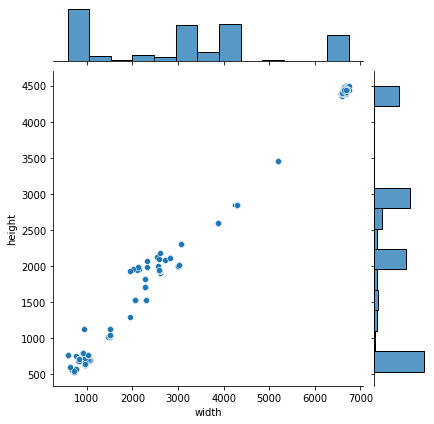

In [32]:
import seaborn as sns
sns.jointplot(data=sizes, x='width', y='height')


# There are a few dominant image aspects, and indeed 1024x768 seems like a decent starting point

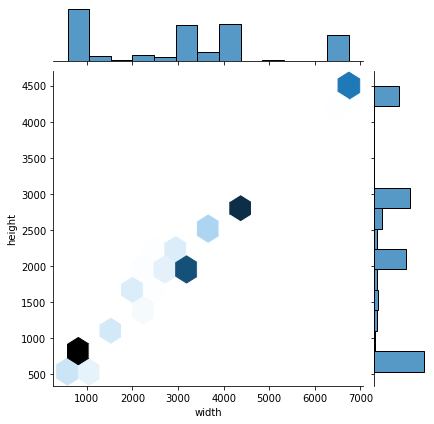

In [30]:
sns.jointplot(data=sizes, x='width', y='height', kind='hex')

In [44]:
sizes[['width', 'height']].value_counts().head(20)

width  height
4288   2848      558
1024   768       556
3008   2000      379
3872   2592      125
3024   2016      100
767    576        63
2048   1536       56
3072   2304       53
1504   1129       50
919    802        49
2592   1936       34
6688   4439       32
6668   4439       30
1022   767        20
6648   4439       19
6688   4459       19
6708   4439       19
2304   1536       16
824    719        16
6668   4459       11
dtype: int64

## The 1024x768 image size was my starting point, but overall I found that the batch size couldn't reliably exceed 1! The server I just built was specifically purchased to do minibatch splitting, and I may explore this further, but in the interests of time I decided to downsample to 512x512. That gave a reasonable batchsize of 4 for most experiments on single 12GB Nvidia K80 cards.
### Since some of these images are huge, experience has taught me that manually resizing them is best for training speed. Easily done with imagemagick. Note : these were executed on the commandline on a remote deep learning server

#### An example workflow for multithreaded resizing

```
mkdir training_resized
mkdir training_masks_resized
mkdir validation_resized
mkdir validation_masks_resized

mogrify -resize 1024x768 -quality 100 -path training_resized/ ISIC2018_Task1-2_Training_Input/*.jpg
mogrify -resize 1024x768 -quality 100 -path training_masks_resized/ ISIC2018_Task1_Training_GroundTruth/*.png
mogrify -resize 1024x768 -quality 100 -path validation_resized/ ISIC2018_Task1-2_Validation_Input/*.jpg
mogrify -resize 1024x768 -quality 100 -path validation_masks_resized/ ISIC2018_Task1_Validation_GroundTruth/*.png

```


### In the cells below, I refactored some data loaders from the example project from the segmentation models library. These were later moved into the main repository outside of jupyter.

In [201]:
def padding(img, yy, xx):
    print('shape is ', img.shape)
    #if img.shape != (768, 1024,3):
    #    raise ValueError()

    """
    :param img: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = img.shape[0]
    w = img.shape[1]
    #print(h, yy, w, xx)

    if h == yy and w == xx:
        return img

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    if img.shape[-1]==1:
        return np.pad(img, pad_width=((a, aa), (b, bb)), mode='constant')
    elif img.shape[-1]==3:
        img = np.stack(
            [np.pad(img[:, :, c], pad_width=((a, aa), (b, bb)),
            mode='constant', constant_values=0) for c in range(3)], axis=2
        )
        return img
    else:
        raise ValueError('Not a B&W or RGB image? I have no idea what to do here ...')


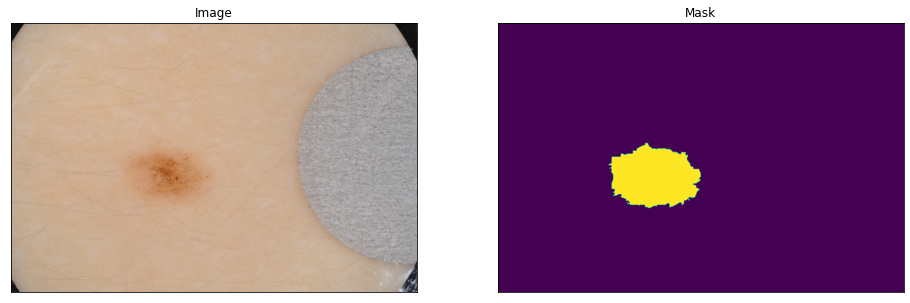

In [199]:
#import keras
from tensorflow import keras as keras
import os
import matplotlib.pyplot as plt

# helper functions for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

def denormalize(x):    # Scale image to range 0..1 for correct plot

    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x


class Dataset:

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
            paddingShape=None
    ):
        #self.ids = os.listdir(images_dir)
        self.paddingShape = paddingShape

        self.images = glob(images_dir+'*.jpg')
        filenames = [os.path.split(fn)[1] for fn in self.images]
        masks = [fn.replace('.jpg','_segmentation.png') for fn in filenames]
        self.masks = [os.path.join(masks_dir, fn) for fn in masks]

        # convert str names to class values on masks
        #self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def loadImg(self, fn):
        image = cv2.imread(fn)
        if self.paddingShape:
            image = padding(image, self.paddingShape[0], self.paddingShape[1])
        return image
        
    def __getitem__(self, i):

        # read data
        image = self.loadImg(self.images[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #mask = cv2.imread(self.masks[i], 0)
        mask = self.loadImg(self.masks[i])
        mask = mask[:,:,0]
        mask[mask>0]=1
        if mask is None:
            raise ValueError(f"Couldn't load mask : {self.masks[i]}")

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.images)


class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches

    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """

    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
            

images = '../data/ISIC2018_Task1-2_Training_Input/'
masks = '../data/ISIC2018_Task1_Training_GroundTruth/'

dataset = Dataset(images, masks)

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    mask=mask#[..., 0].squeeze()
)



0
shape is  (677, 1024, 3)
shape is  (677, 1024, 3)


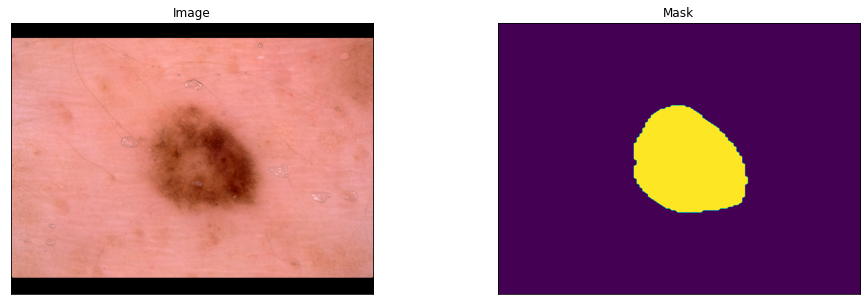

1
shape is  (768, 1024, 3)
shape is  (768, 1024, 3)


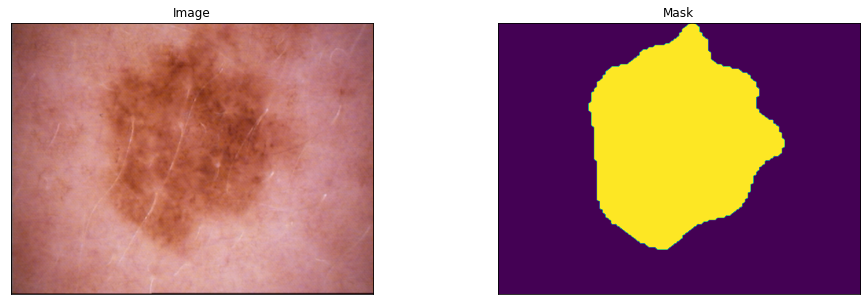

In [203]:
images = '../data/validation_resized/'
masks = '../data/validation_masks_resized/'

dataset = Dataset(images, masks, paddingShape=(1024,768))

for i in range(0,2):
    print(i)
    image, mask = dataset[i] # get some sample

    visualize(
        image=image, 
        mask=mask#[..., 0].squeeze()
    )


#### I wasted at least an hour trying to track down a bug caused by the PNG mask images having odd pixel values! Grrr.

In [78]:
np.unique(mask, return_counts=True)

(array([0, 1], dtype=uint8), array([11735541,   476683]))

### For augmentations, I use the Albumentations library. This is the first time Ive used it and its simply amazing, lightyears ahead of the Keras streaming augmentation pipeline that I previously used.

In [130]:
import albumentations as A


def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        #A.RandomCrop(height=320, width=320, always_apply=True),

        #A.IAAAdditiveGaussianNoise(p=0.2),
        A.augmentations.transforms.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.2),
        #A.IAAPerspective(p=0.5),
        A.augmentations.geometric.transforms.Perspective(scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1, always_apply=False, p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                #A.IAASharpen(p=1),
                A.augmentations.transforms.Sharpen (alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=1.0),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

#### Testing Augmentations - looks a little different each time the cell is executed. I can tell already that this pipeline gives incredible diversity in images.

../data/ISIC2018_Task1-2_Training_Input/ISIC_0014754.jpg
mask shape is  (4399, 6648)


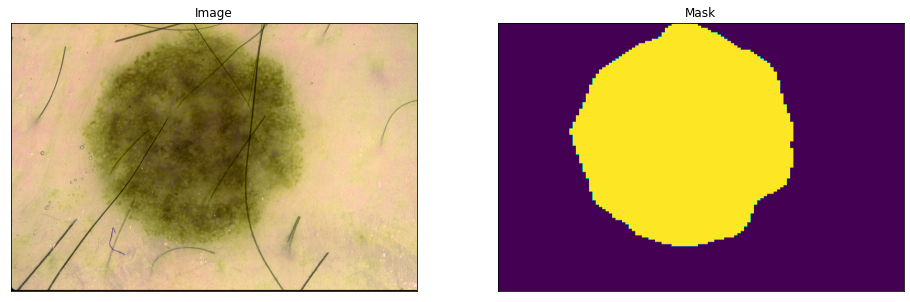

In [133]:
images = '../data/ISIC2018_Task1-2_Training_Input/'
masks = '../data/ISIC2018_Task1_Training_GroundTruth/'

dataset = Dataset(images, masks, augmentation=get_training_augmentation())

ID = 56

print(dataset.images[ID])
image, mask = dataset[ID] # get some sample
visualize(
    image=image, 
    mask=mask#[..., 0].squeeze(),
)

../data/validation_resized/ISIC_0015351.jpg
mask shape is  (685, 1024)


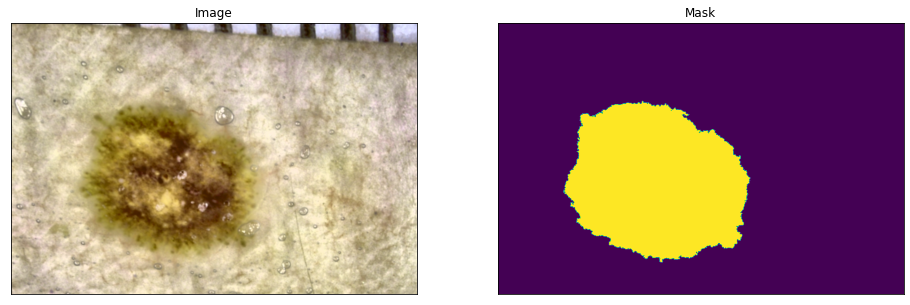

In [163]:
images = '../data/validation_resized/'
masks = '../data/validation_masks_resized/'

dataset = Dataset(images, masks, augmentation=get_training_augmentation())

ID = 56

print(dataset.images[ID])
image, mask = dataset[ID] # get some sample
visualize(
    image=image, 
    mask=mask#[..., 0].squeeze(),
)

# Done prototyping

### From here, many of these pieces were cleaned up and placed into the main repository (using pycharm IDE). The training loop was assembled there with commandline parameters so that hyperparameter experiments could be easily executed on the new server I just finished building. (6 working k80 cards!)